# Preparing

## Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth
from utils import *
from joblib import Parallel, delayed
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams.update({"font.size": 16,'lines.linewidth': 2.5})
import portion as P
# matplotlib.rcdefaults()

figures saved to /tmp/figures


In [2]:
DATA_DIR = 'processed_csv/'
dfa = pd.read_csv(DATA_DIR + 'dfa.csv') # dataframe of tasks
dfas = pd.read_csv(DATA_DIR + 'dfas.csv') # tasks with sensor data but sum
dfam = pd.read_csv(DATA_DIR + 'dfas_mean.csv') # tasks with sensor data but mean

In [3]:
# figure out which job_name has appeared in multiple rows
count_series = dfa['job_name'].value_counts()
dup_task = count_series[count_series > 1].index.to_list()
names = ['tensorflow', 'worker', 'ps', 'PyTorchWorker', 'evaluator']
fail = 'Failed'
gpu_types = ['V100', 'T4', 'P100', 'V100M32']
# usr_vals = dfa.user.value_counts()
# threshold = np.percentile(usr_vals, all_thr)
# freq_user = usr_vals[usr_vals >= threshold].index.to_list()

In [45]:
dfas['plan_gpu'].value_counts()[1] / len(dfas)

0.00015175881406957143

In [4]:
# figure out high level and low level requests for cpu, gpu and memory
cpu_req_1st = P.closedopen(0, np.percentile(dfas['plan_cpu'], 25))
cpu_req_med = P.closedopen(np.percentile(dfas['plan_cpu'], 25), np.percentile(dfas['plan_cpu'], 75))
cpu_req_4th = P.closed(np.percentile(dfas['plan_cpu'], 75), dfas['plan_cpu'].max())

gpu_req_1st = P.closedopen(0, np.percentile(dfas['plan_gpu'], 25))
gpu_req_2nd = P.closedopen(np.percentile(dfas['plan_gpu'], 25), np.percentile(dfas['plan_gpu'], 50))
gpu_req_3rd = P.closedopen(np.percentile(dfas['plan_gpu'], 50), np.percentile(dfas['plan_gpu'], 81.8))
gpu_req_4th = P.closed(np.percentile(dfas['plan_gpu'], 81.8), dfas['plan_gpu'].max())

mem_req_1st = P.closedopen(0, np.percentile(dfas['plan_mem'], 25))
mem_req_med = P.closedopen(np.percentile(dfas['plan_mem'], 25), np.percentile(dfas['plan_mem'], 78))
mem_req_4th = P.closed(np.percentile(dfas['plan_mem'], 78), dfas['plan_mem'].max())

dfas_runtime = dfas['runtime'][~np.isnan(dfas['runtime'])]
runtime_1st = P.closedopen(0, np.percentile(dfas_runtime, 25))
runtime_2nd = P.closedopen(np.percentile(dfas_runtime, 25), np.percentile(dfas_runtime, 50))
runtime_3rd = P.closedopen(np.percentile(dfas_runtime, 50), np.percentile(dfas_runtime, 75))
runtime_4th = P.closed(np.percentile(dfas_runtime, 75), dfas_runtime.max())

dfas_wait = dfas['wait_time'][~np.isnan(dfas['wait_time'])]
wait_1st = P.closedopen(0, np.percentile(dfas_wait, 25))
wait_2nd = P.closedopen(np.percentile(dfas_wait, 25), np.percentile(dfas_wait, 50))
wait_3rd = P.closedopen(np.percentile(dfas_wait, 50), np.percentile(dfas_wait, 75))
wait_4th = P.closed(np.percentile(dfas_wait, 75), dfas_wait.max())

#TODO: need to choose from CDF, not hard threshold
ins_high = 2
model_dict = {'inception': 'cv', 'resnet': 'cv', 'vgg': 'cv',
             'bert': 'text', 'nmt': 'text', 'xlnet': 'text',
             'graphlearn': 'gnn', 'rl': 'rl', 'ctr': 'rec'}

# plot_data_cdf(dfas['user'].value_counts(), xlog=True)
#               ylabel='CDF',xlabel='Num of tasks submitted per User',
#               xticks=[1,10,100,10**3,10**4,10**5])

In [5]:
bot_user_thr = get_usr_thr(dfas['user'], mode='bot')
top_user_thr = get_usr_thr(dfas['user'], mode='top')
user_counts = dfas['user'].value_counts()
new_users = user_counts[user_counts <= bot_user_thr].index.to_list()
top_users = user_counts[user_counts >= top_user_thr].index.to_list()

bot_grp_thr = get_usr_thr(dfas['group'], mode='bot')
top_grp_thr = get_usr_thr(dfas['group'], mode='top')
group_counts = dfas['group'].value_counts()
nonfreq_groups = group_counts[group_counts <= bot_grp_thr].index.to_list()
freq_groups = group_counts[group_counts >= top_grp_thr].index.to_list()

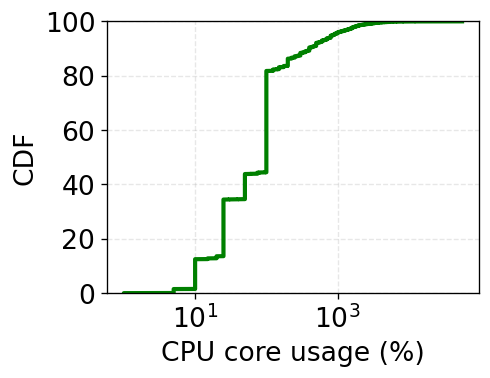

In [42]:
plot_data_cdf(dfas['plan_gpu'], xlog=True, xlabel='CPU core usage (%)')

In [61]:
dfas.user.nunique()

1242

In [7]:
%%script false --no-raise-error
csum_use_high = np.percentile(dfas['cpu_usage'][~np.isnan(dfas['cpu_usage'])], 85)
csum_use_low = np.percentile(dfas['cpu_usage'][~np.isnan(dfas['cpu_usage'])], 15)
gsum_use_high = np.percentile(dfas['gpu_wrk_util'][~np.isnan(dfas['gpu_wrk_util'])], 85)
gsum_use_low = np.percentile(dfas['gpu_wrk_util'][~np.isnan(dfas['gpu_wrk_util'])], 15) # just 0
msum_use_high = np.percentile(dfas['avg_mem'][~np.isnan(dfas['avg_mem'])], 85)
msum_use_low = np.percentile(dfas['avg_mem'][~np.isnan(dfas['avg_mem'])], 15)
gmsum_use_high = np.percentile(dfas['avg_gpu_wrk_mem'][~np.isnan(dfas['avg_gpu_wrk_mem'])], 85)
gmsum_use_low = np.percentile(dfas['avg_gpu_wrk_mem'][~np.isnan(dfas['avg_gpu_wrk_mem'])], 15) # just 0

In [8]:
# figure out usage thresholds from dfam
cavg_use = dfam['cpu_usage'][~np.isnan(dfam['cpu_usage'])]
cavg_use_1st = P.closedopen(0, np.percentile(cavg_use, 25))
cavg_use_2nd = P.closedopen(np.percentile(cavg_use, 25), np.percentile(cavg_use, 50))
cavg_use_3rd = P.closedopen(np.percentile(cavg_use, 50), np.percentile(cavg_use, 75))
cavg_use_4th = P.closed(np.percentile(cavg_use, 75), cavg_use.max())

gavg_use = dfam['gpu_wrk_util'][~np.isnan(dfam['gpu_wrk_util'])]
gavg_use_low = P.closedopen(0, np.percentile(gavg_use, 50))
gavg_use_3rd = P.closedopen(np.percentile(gavg_use, 50), np.percentile(gavg_use, 75))
gavg_use_4th = P.closed(np.percentile(gavg_use, 75), gavg_use.max())

mavg_use = dfam['avg_mem'][~np.isnan(dfam['avg_mem'])]
mavg_use_1st = P.closedopen(0, np.percentile(mavg_use, 25))
mavg_use_2nd = P.closedopen(np.percentile(mavg_use, 25), np.percentile(mavg_use, 50))
mavg_use_3rd = P.closedopen(np.percentile(mavg_use, 50), np.percentile(mavg_use, 75))
mavg_use_4th = P.closed(np.percentile(mavg_use, 75), mavg_use.max())

gmavg_use = dfam['avg_gpu_wrk_mem'][~np.isnan(dfam['avg_gpu_wrk_mem'])]
gmavg_use_1st = P.closedopen(0, np.percentile(gmavg_use, 27))
gmavg_use_2nd = P.closedopen(np.percentile(gmavg_use, 27), np.percentile(gmavg_use, 50))
gmavg_use_3rd = P.closedopen(np.percentile(gmavg_use, 50), np.percentile(gmavg_use, 75))
gmavg_use_4th = P.closed(np.percentile(gmavg_use, 75), gmavg_use.max())

In [57]:
dfas['gpu_type'].value_counts()

MISC       577777
T4         175507
P100        56975
V100        23978
V100M32     15795
Name: gpu_type, dtype: int64

In [9]:
def inner_loop(dfas, dfam):
    results = []
    for dfas_iter, dfam_iter in zip(dfas.iterrows(), dfam.iterrows()):
        trans = [] # transaction list
        dfas_row = dfas_iter[1]
        dfam_row = dfam_iter[1]
        if dfas_row['job_name'] in dup_task:
            trans.append('multi-task')
        if dfas_row['task_name'] in names:
            trans.append(dfas_row['task_name'])
        if dfas_row['status'] == fail:
            trans.append(fail)
        if dfas_row['gpu_type'] in gpu_types:
            if dfas_row['gpu_type'] == 'T4':
                trans.append('T4')
            else:
                trans.append('None-T4')
        else:
            trans.append('Unspecified-GPU')
        # cpu req
        cpu_req = dfas_row['plan_cpu']
        if cpu_req in cpu_req_1st:
            trans.append('cpu_req_1st')
        elif cpu_req in cpu_req_med:
            trans.append('cpu_req_med')
        elif cpu_req in cpu_req_4th:
            trans.append('cpu_req_4th')
        # gpu req
        gpu_req = dfas_row['plan_gpu']
        if gpu_req in gpu_req_1st:
            trans.append('gpu_req_1st')
        elif gpu_req in gpu_req_2nd:
            trans.append('gpu_req_2nd')
        elif gpu_req in gpu_req_3rd:
            trans.append('gpu_req_3rd')
        elif gpu_req in gpu_req_4th:
            trans.append('gpu_req_4th')
        # mem req
        mem_req = dfas_row['plan_mem']
        if mem_req in mem_req_1st:
            trans.append('mem_req_1st')
        elif mem_req in mem_req_med:
            trans.append('mem_req_med')    
        elif mem_req in mem_req_4th:
            trans.append('mem_req_4th')
        # runtime
        runtime = dfas_row['runtime']
        if not np.isnan(runtime):
            if runtime in runtime_1st:
                trans.append('runtime_1st')
            elif runtime in runtime_2nd:
                trans.append('runtime_2nd')   
            elif runtime in runtime_3rd:
                trans.append('runtime_3rd')
            elif runtime in runtime_4th:
                trans.append('runtime_4th')
        # wait time
        wait = dfas_row['wait_time']
        if not np.isnan(wait):
            if wait in wait_1st:
                trans.append('wait_1st')
            elif wait in wait_2nd:
                trans.append('wait_2nd')
            elif wait in wait_3rd:
                trans.append('wait_3rd')
            elif wait in wait_4th:
                trans.append('wait_4th')
        if wait >= runtime:
            trans.append('wait >= run')
        # multiple instance spawned
        if dfas_row['inst_num'] >= ins_high:
            trans.append('multi-inst')
        # model type
        model = dfas_row['workload']
        if model in model_dict:
            trans.append(model_dict[model])
        # freq user and job group
        if dfas_row['group'] in freq_groups:
            trans.append('freq_group')
        elif dfas_row['group'] in nonfreq_groups:
            trans.append('nonfreq_group')
        if dfas_row['user'] in new_users:
            trans.append('new_user')
        elif dfas_row['user'] in top_users:
            trans.append('top_user')
        # cpu/gpu/memory usage average across instances        
        cpu_use_avg = dfam_row['cpu_usage']
        if not np.isnan(cpu_use_avg):
            if cpu_use_avg in cavg_use_1st:
                trans.append('cpu_avg_1st')
            elif cpu_use_avg in cavg_use_2nd:
                trans.append('cpu_avg_2nd')
            elif cpu_use_avg in cavg_use_3rd:
                trans.append('cpu_avg_3rd')
            elif cpu_use_avg in cavg_use_4th:
                trans.append('cpu_avg_4th')        
                
        gpu_use_avg = dfam_row['gpu_wrk_util']
        if not np.isnan(gpu_use_avg):
            if gpu_use_avg in gavg_use_low:
                trans.append('gpu_avg_low')
            elif gpu_use_avg in gavg_use_3rd:
                trans.append('gpu_avg_3rd')
            elif gpu_use_avg in gavg_use_4th:
                trans.append('gpu_avg_4th')
                
        mem_use_avg = dfam_row['avg_mem']
        if not np.isnan(mem_use_avg):
            if mem_use_avg in mavg_use_1st:
                trans.append('mem_avg_1st')
            elif mem_use_avg in mavg_use_2nd:
                trans.append('mem_avg_2nd')
            elif mem_use_avg in mavg_use_3rd:
                trans.append('mem_avg_3rd')
            elif mem_use_avg in mavg_use_4th:
                trans.append('mem_avg_4th')
                
        gmem_use_avg = dfam_row['avg_gpu_wrk_mem']
        if not np.isnan(gmem_use_avg):
            if gmem_use_avg in gmavg_use_1st:
                trans.append('gmem_avg_1st')
            elif gmem_use_avg in gmavg_use_2nd:
                trans.append('gmem_avg_2nd')      
            elif gmem_use_avg in gmavg_use_3rd:
                trans.append('gmem_avg_3rd')      
            elif gmem_use_avg in gmavg_use_4th:
                trans.append('gmem_avg_4th')      
        results.append(trans)
    return results

In [10]:
dfas_chunk = pd.read_csv(DATA_DIR + 'dfas.csv', chunksize=10000) # tasks with sensor data but sum
dfam_chunk = pd.read_csv(DATA_DIR + 'dfas_mean.csv', chunksize=10000) # tasks with sensor data but mean

In [11]:
usable_cores = os.sched_getaffinity(0)
dataset = Parallel(n_jobs=len(usable_cores))(delayed(inner_loop)(dfas, dfam) for dfas, dfam in zip(dfas_chunk, dfam_chunk))

In [12]:
transactions = []
for data in dataset:
    transactions += data

In [20]:
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [22]:
df.to_csv('transaction.csv')

In [21]:
frequent_itemsets = fpgrowth(df, min_support=0.1, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.692441,(mem_req_med)
1,0.679712,(Unspecified-GPU)
2,0.602671,(tensorflow)
3,0.544666,(cpu_req_med)
4,0.308629,(gpu_req_2nd)
...,...,...
874,0.115491,"(tensorflow, gpu_avg_low, gpu_req_1st, Unspecified-GPU)"
875,0.115490,"(tensorflow, mem_req_med, gpu_req_1st, gpu_avg_low, Unspecified-GPU)"
876,0.102985,"(top_user, mem_req_med, gpu_req_1st)"
877,0.100553,"(top_user, gpu_req_1st, Unspecified-GPU)"


In [15]:
from mlxtend.frequent_patterns import association_rules

res = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.8)

In [16]:
res

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(tensorflow),(mem_req_med),0.602671,0.692441,0.602657,0.999977,1.444132,0.185342,13129.934970
1,(mem_req_med),(tensorflow),0.692441,0.602671,0.602657,0.870336,1.444132,0.185342,3.064298
2,(tensorflow),(Unspecified-GPU),0.602671,0.679712,0.492583,0.817334,1.202470,0.082940,1.753405
3,"(tensorflow, mem_req_med)",(Unspecified-GPU),0.602657,0.679712,0.492570,0.817332,1.202467,0.082937,1.753382
4,"(tensorflow, Unspecified-GPU)",(mem_req_med),0.492583,0.692441,0.492570,0.999974,1.444128,0.151485,11707.136046
...,...,...,...,...,...,...,...,...,...
2259,"(top_user, gpu_req_1st)",(Unspecified-GPU),0.103383,0.679712,0.100553,0.972621,1.430931,0.030282,11.698483
2260,"(top_user, mem_req_med, gpu_req_1st)",(Unspecified-GPU),0.102985,0.679712,0.100158,0.972550,1.430826,0.030158,11.668037
2261,"(top_user, gpu_req_1st, Unspecified-GPU)",(mem_req_med),0.100553,0.692441,0.100158,0.996081,1.438505,0.030532,78.471523
2262,"(mem_req_med, gpu_req_1st, Unspecified-GPU)",(top_user),0.124300,0.293476,0.100158,0.805781,2.745648,0.063679,3.637769


In [17]:
df_ant, df_con = filter_df(res, 'gpu_avg_low')
df_ant.to_csv('pai_low_util_ant.csv')
df_con.to_csv('pai_low_util_con.csv')

In [18]:
# res.to_csv('mined_rule_pai.csv')

In [19]:
    # cpu/gpu/memory usage sum
#     cpu_use_sum = dfas['cpu_usage'][ind]
#     if not np.isnan(cpu_use_sum):
#         if cpu_use_sum >= csum_use_high:
#             trans.append('high_cpu_sum')
#         elif cpu_use_sum <= csum_use_low:
#             trans.append('low_cpu_sum')
#     gpu_use_sum = dfas['gpu_wrk_util'][ind]
#     if not np.isnan(gpu_use_sum):
#         if gpu_use_sum >= gsum_use_high:
#             trans.append('high_gpu_sum')
#         elif gpu_use_sum <= gsum_use_low:
#             trans.append('low_gpu_sum')
#     mem_use_sum = dfas['avg_mem'][ind]
#     if not np.isnan(mem_use_sum):
#         if mem_use_sum >= msum_use_high:
#             trans.append('high_mem_sum')
#         elif mem_use_sum <= msum_use_low:
#             trans.append('low_mem_sum')    
#     gmem_use_sum = dfas['avg_gpu_wrk_mem'][ind]
#     if not np.isnan(gmem_use_sum):
#         if gmem_use_sum >= gmsum_use_high:
#             trans.append('high_gmem_sum')
#         elif gmem_use_sum <= gmsum_use_low:
#             trans.append('low_gmem_sum')        